In [1]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.cluster as sklearn

(a) Implement the PSO algorithm for clustering described in “Van der Merwe, D.
W., and Andries Petrus Engelbrecht. ”Data clustering using particle swarm
optimization.” Evolutionary Computation, 2003. CEC’03. The 2003 Congress
on. Vol. 1. IEEE, 2003.” (see also the lecture’s slides on swarm intelligence).

In [2]:
# Define Function to initialize population
def init_population(size:int, K:int, dataset:np.ndarray) -> np.ndarray:
    """Generates a population of particles as a Matrix of shape (num_particles, K, data_dim). 
    A particle is a Matrix of length <K> where each column represents a centroid. The amount of rows
    is equal to the dimensionality of the data that we want to cluster

    Args:
        size (int): The amount of particles 
        K (int): The dimensionality of each particle
        dataset (np.ndarray): The dataset that we want to apply clustering on

    Returns:
        (np.ndarray): The population in Matrix form
    """
    num_datapoints, num_dimensions = dataset.shape
    # Zero-Init the population
    population = np.zeros([size, K, num_dimensions])
    # Loop over range of population to fill it with random individuals
    for i in range(size):
        # Get random indices to pick datapoints from the dataset
        # Each datapoint will be one cluster centroid for this particle
        indices = np.random.randint(num_datapoints, size=K)
        # Populate using the collected datapoints
        population[i] = dataset[indices, :]

    return population

In [3]:
# Testing the Population Initialization

# Create test datasets
test_data = np.array([[1,2,3]])
# Creating a single individual population for a single cluster from a dataset with a single entry should give us that datapoint as the individual
assert init_population(size=1,K=1,dataset=test_data).shape == (1,1,3)
assert np.all(init_population(size=1,K=1,dataset=test_data) == [[[1,2,3]]])

# If we have two clusters, the 2 centroids should both be equal to the datapoint
assert init_population(size=1,K=2,dataset=test_data).shape == (1,2,3)
assert np.all(init_population(size=1,K=2,dataset=test_data) == [[[1,2,3], [1,2,3]]])

# If we have two individuals with one cluster each, they both contain the randomly selected datapoint as the centroid
assert init_population(size=2,K=1,dataset=test_data).shape == (2,1,3)
assert np.all(init_population(size=2,K=1,dataset=test_data) == [[[1,2,3]], [[1,2,3]]])

test_data = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])

assert init_population(4,4,test_data).shape == (4,4,3)
assert init_population(size=10, K=4, dataset=test_data).shape == (10,4,3)

$d(x,y) = \sqrt{\sum_{k=1}^{N_d} (x_k - y_k)^2}$

In [4]:
def calc_distance(x:np.ndarray, y:np.ndarray) -> float:
    """Calculates the euclidean distance between point <x> and point <y>.

    Args:
        p1 (np.ndarray): point1
        p2 (np.ndarray): point2

    Returns:
        float: The distance between the points
    """
    return np.linalg.norm(x-y)

# Sanity check
assert calc_distance(np.array([5,5]), np.array([6,6])) == 1.4142135623730951

In [5]:
# Define Fitness Function
def calc_fitness(assignments: np.ndarray, dataset: np.ndarray, particle:np.ndarray) -> float:
    """Calculates the fitness of a particle given a K-cluster problem setup. Each entry in the particle is
    treated as a centroid for a cluster. Calculates the normalized
    sum of euclidean distances between centroids and assigned datapoints. 

    Args:
        assignments (np.ndarray): Stores the cluster index for each datapoint
        dataset (np.ndarray): The datapoints 
        particle (np.ndarray): The centroid Matrix

    Returns:
        float: Fitness of the particle
    """
    num_clusters, _ = particle.shape
    fitness = 0
    for cluster_idx, centroid in enumerate(particle):
        # Get all datapoints that were assigned to this cluster
        boolean_mask = assignments==cluster_idx
        datapoints = dataset[boolean_mask]
        if datapoints.shape[0] > 0:
            # Calculate the sum of distances between the datapoints and the centroid
            total_distance = 0
            for datapoint in datapoints:
                total_distance += calc_distance(centroid, datapoint)
            #normalize by the amount of assigned datapoints and add to the fitness
            fitness +=  total_distance / len(datapoints)
    # Normalize by the amount of clusters
    fitness /= num_clusters
    return fitness

In [6]:
# Testing the fitness function

# single datapoint
test_ass = np.array([0])
test_data = np.zeros([1,2])+5
# one cluster
test_part = np.zeros([1,2])+6

assert calc_fitness(test_ass, test_data, test_part) == 1.4142135623730951

# two datapoints with single cluster
test_ass = np.array([0, 0])
test_data = np.zeros([2,2])
test_data[0] += 4
test_data[1] += 5

correct = (calc_distance(np.array([4,4]), np.array([6,6])) + calc_distance(np.array([5,5]), np.array([6,6]))) / 2
assert calc_fitness(test_ass, test_data, test_part) == correct


$v_i := \omega\times v_i + \alpha_1\times r_1\circ (\hat{x} - x_i) + \alpha_2\times r_2\circ (\hat{g} - x_i)$

In [7]:
# Define Function to update the velocity of a particle
def update_velocity(vel, local_best, global_best, current, omega, alpha1, alpha2) -> np.ndarray:
    """Updates the velocity <vel> of the <current> particle according to the PSO velocity update

    Args:
        vel (np.ndarray): Defines the velocity of the particle
        local_best (np.ndarray): Stores the fittest version of this particle found so far
        global_best (np.ndarray): Stores the fittest particle of the population found so far
        current (np.ndarray): The current particle
        omega (float): Inertia weight
        alpha1 (float): weight param for the local influence
        alpha2 (float): weight param for the social influence

    Returns:
        np.ndarray: The updated velocity
    """
    # Generate r1 and r2 from uniform distribution
    r1 = np.random.uniform(0,1)
    r2 = np.random.uniform(0,1)
    return omega*vel + alpha1*r1*(local_best - current) + alpha2*r2*(global_best - current)

$x_i := x_i + v_i$

In [8]:
# Define Function for the position update
def update_position(current, velocity) -> np.ndarray:
    """Updates the position <current>, using the <velocity> according to the PSO position update rule
    Args:
        current (np.ndarray): The current particle
        velocity (np.ndarray): The velocity of the particle

    Returns:
        np.ndarray: The updated particle position
    """
    new_pos = current + velocity
    return new_pos

<ol>
  <li>Initialize each particle to contain N randomly selected centroids</li>
  <li>
    For iter=1 to maxiter:
    <ul>
      <li> 
        For each particle x:
        <ul>
          <li> For each data point z:</li>
          <ul>
            <li> Calculate the distance of z to each cluster centroid </li>
            <li> Assign z to the cluster (centroid) with minimal distance; </li>
          </ul>
          <li> Compute the fitness (e.g. average weighted distance of data points 
            from their centroid); </li>
          <li> Update the local best; </li>
        </ul>
        <li> Update the global best; </li>
        <li> Update each particle !"using PSO update rules </li>
      </li>
    </ul>
  </li>
</ol> 

In [9]:
# Define a function that runs the K-Means PSO algorithm
def k_means_PSO(K:int, data_dim: int, dataset:np.ndarray, pop_size:int, max_iter:int, omega:float, alpha1:float, alpha2:float) -> np.ndarray:
    """Runs a K-Means PSO algorithm for <max_iter> iterations to find a set of <K> clusters for a dataset.

    Args:
        K (int): The amount of clusters to separate the data into
        data_dim (int): The dimensionality of the data
        dataset (np.ndarray): The datapoints that should be clustered
        pop_size (int): The amount of particles to run the PSO algorithm with
        max_iter (int): The maximum amount of iterations to run PSO for
        omega (float): Inertia weight
        alpha1 (float): local influence param
        alpha2 (float): social influence param

    Returns:
        np.ndarray: The best clustering found through the algorithm
    """
    # Define initial population (1.)
    population = init_population(pop_size, K, dataset)
    # Create a copy of the population to store the best versions found so far for each particle
    local_best = population.copy()
    # Store the local best fitnesses to avoid recomputing
    local_best_f = np.zeros(pop_size)
    # Ensure that the first iteration will have a lower fitness than the prepopulated fitnesses
    local_best_f += float("inf")
    # Zero-initialize the velocities of each particle
    velocities = np.zeros([pop_size, K, data_dim])
    # Collect best fitness per iteration 
    fitness_history = []
    # Run the iterations (2.)
    for i in range(max_iter):
        # Loop over each particle 
        for idx, particle in enumerate(population):
            # Collect the assignments of each datapoint for the particle
            assignments = []
            # Loop over each datapoint
            for z in dataset:
                # Collect the distance to each centroid
                distances = []
                # Calculate the distance for every cluster centroid
                for centroid in particle:
                    # Get the distance between the centroid and the datapoint
                    distance = calc_distance(centroid, z)
                    # Add the distance to the collector
                    distances.append(distance)
                # The datapoint is assigned to the cluster that minimizes the distance between centroid and datapoint
                assignments.append(np.argmin(distances))
            # Calculate the fitness of the particle given the new assignments
            fitness = calc_fitness(np.array(assignments), dataset, particle)
            # Update the local best if the new fitness is higher than that of the previous local best
            if fitness < local_best_f[idx]:
                local_best[idx] = particle.copy()
                local_best_f[idx] = fitness
        # Update the global best to be the best of the local_best
        best_idx = np.argmin(local_best_f)
        global_best = local_best[best_idx].copy()
        global_best_f = np.min(local_best_f)
        fitness_history.append(global_best_f)
        # Update the position and velocity of each particle
        for i in range(pop_size):
            velocities[i] = update_velocity(velocities[i], local_best[i], global_best, population[i], omega, alpha1, alpha2)
            population[i] = update_position(population[i], velocities[i])
    return global_best, global_best_f, fitness_history   

(b) Implement the k-means clustering method.

In [10]:
# Define a K-Means Clustering function
def K_Means(K:int, dataset:np.ndarray, iters:int, num_inits:int) -> np.ndarray:
    """Performs <iters> iterations of K-Means Clustering on a given <dataset> into <K> classes

    Args:
        K (int): amount of clusters
        dataset (np.ndarray): The set of datapoints to cluster
        iters (int): The amount of iterations
        num_inits (int): The amount of times the algorithm will be run with different centroid seeds

    Returns:
        np.ndarray: The centroids of each cluster
    """
    # Get the dimensionality of the dataset
    num_datapoints, num_dimensions = dataset.shape
    best = np.zeros([K, num_dimensions])
    best_f = float("inf")
    fitness_history = []
    for i in range(num_inits):
        current_history = []
        # Randomly initialize a set of cluster centroids
        indices = np.random.randint(num_datapoints, size=K)
        clusters = dataset[indices, :]
        assert clusters.shape == (K, num_dimensions)
        # Collect the assignments
        assignments = []
        # Run <iters> iterations of clustering updates
        for i in range(iters):
            # Assignment Step: Assign each datapoint to the closest cluster
            assignments.clear()
            # Iterate over each datapoint in the dataset
            for z in dataset:
                # Collect the distance to each cluster centroid
                distances = []
                for cluster in clusters:
                    distances.append(calc_distance(cluster, z))
                # The datapoint is assigned to the cluster that minimizes the distance between centroid and datapoint
                assignments.append(np.argmin(distances))
            # Update Step: Update each centroid to be the average of the assigned datapoints
            for cluster_idx in range(K):
                # Calculate a boolean mask that is true at each index where the datapoint is assigned to the current cluster
                boolean_mask = np.array(assignments) == cluster_idx
                # Use the boolean mask to filter out all assigned datapoints
                cluster_points = dataset[boolean_mask]
                # Update the cluster centroid using the average of all assigned datapoints
                clusters[cluster_idx] = np.average(cluster_points, axis=0)
            current_history.append(calc_fitness(np.array(assignments), dataset, clusters))
        # Use the final assignments and centroids to calculate the fitness of the iteration
        current_f = calc_fitness(np.array(assignments), dataset, clusters)
        # If the iteration produced better results than the previous, replace the global best with the current
        if  current_f < best_f:
            best_f = current_f
            best = clusters.copy()
            fitness_history = current_history
    return best, best_f, fitness_history

(c) Generate Artificial dataset 1 using the description given in the above mentioned
paper.


Citing from the Paper: "A total of 400 data vectors were randomly created,
with z1, z2 ∼ U(−1, 1)."

class := 1, if (z1 ≥ 0.7) or ((z1 ≤ 0.3) and (z2 ≥ −0.2 − z1)) 

class := 0 otherwise

Text(0.5, 0.98, 'Visualizing the True clustering of Artificial Dataset 1')

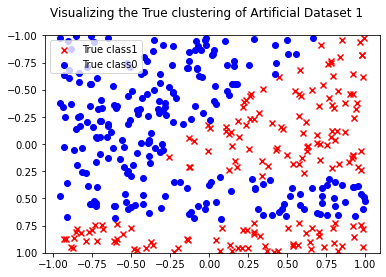

In [31]:
def plot_dataset(plt, dataset):
    """Helper-Function: Produces a plot of the given dataset with classification according to Artificial Problem 1

    Args:
        dataset (np.ndarray): The Dataset
    """
    # Extract the feature vectors from the Dataset
    z1 = dataset[:, 0]
    z2 = dataset[:, 1]
    # Create a boolean mask from the first condition
    cond1 = z1 >= 0.7
    # Create a boolean mask from the second condition, which is a logical AND of two subconditions
    subcond1 = z1 <= 0.3
    subcond2 = z2 >= -0.2 - z1
    subcond_stack = np.stack([subcond1,subcond2], axis=1)
    cond2 = subcond_stack.all(axis=1)
    #Create a Full boolean mask which is a logical OR of the two masks
    full_cond_stack = np.stack([cond1, cond2], axis=1)
    full_cond = full_cond_stack.any(axis=1)
    # Use the mask to define the class sets
    ones = dataset[full_cond]
    zeros = dataset[np.logical_not(full_cond)]
    # The plot in the paper is flipped vertically with the bottom limit being 1 and the top limit -1
    plt.axis(ymax=-1, ymin=1)
    # Plot the class sets
    plt.scatter(ones[:, 1], ones[:, 0], marker="x", color="r", label="True class1")
    plt.scatter(zeros[:, 1], zeros[:, 0], marker="o", color="b", label="True class0")

dataset = np.random.uniform(-1,1,[400,2])
plot_dataset(plt, dataset)
plt.legend(loc="best")
plt.suptitle("Visualizing the True clustering of Artificial Dataset 1")

(d) Apply and compare the performance of the two algorithms in terms of quantization error on Artificial dataset 1 and on the Iris dataset (the latter available at
UCI ML repository, see https://archive.ics.uci.edu/ml/datasets/iris).
In both algorithms, use the true number of clusters as value of the parameter for
setting the number of clusters. Set the initial speed of the PSO particles to 0. In
both algorithms, use some randomly picked datapoints from the dataset as initial
centroids. In order to compute quantization errors, run each algorithm on each
dataset for 30 trials, using 100 iterations in both algorithms, 10 particles for the
PSO algorithm and 10 random initializations for the K-means algorithm.

Part 1) Applying the Algorithms to the Artificial Dataset 1 

In [32]:
# Set Hyperparameters as described
K = 2
iterations = 100
pop_size = 10
trials = 30
num_inits = 10

omega = 0.72
alpha1 = alpha2 = 1.49

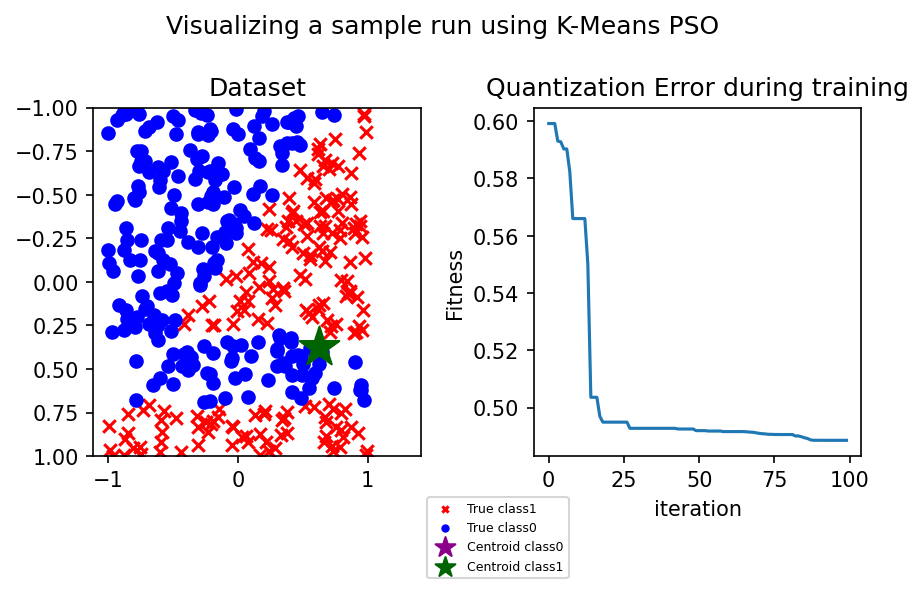

In [33]:
dataset = np.random.uniform(-1,1,[400,2])
# Visualizing a sample run using K-Means PSO
_, num_dimensions = dataset.shape
best, best_fitness, fitness_history = k_means_PSO(K, num_dimensions, dataset, pop_size, iterations, omega, alpha1, alpha2)

cluster_marker = "*"
cluster_color = ["darkmagenta", "darkgreen"]

fig, axs = plt.subplots(1, 2, facecolor="w")

# Plot the results
plot_dataset(axs[0], dataset)
for idx, cluster in enumerate(best):
    axs[0].scatter(cluster[0], cluster[1], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
axs[0].legend(bbox_to_anchor=(1,-0.1), prop={'size': 6}, markerscale=.5)
axs[0].title.set_text("Dataset")
axs[1].plot(np.arange(len(fitness_history)), fitness_history)
axs[1].title.set_text("Quantization Error during training")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("Fitness")
fig.suptitle("Visualizing a sample run using K-Means PSO")
fig.tight_layout()
fig.set_dpi(150)


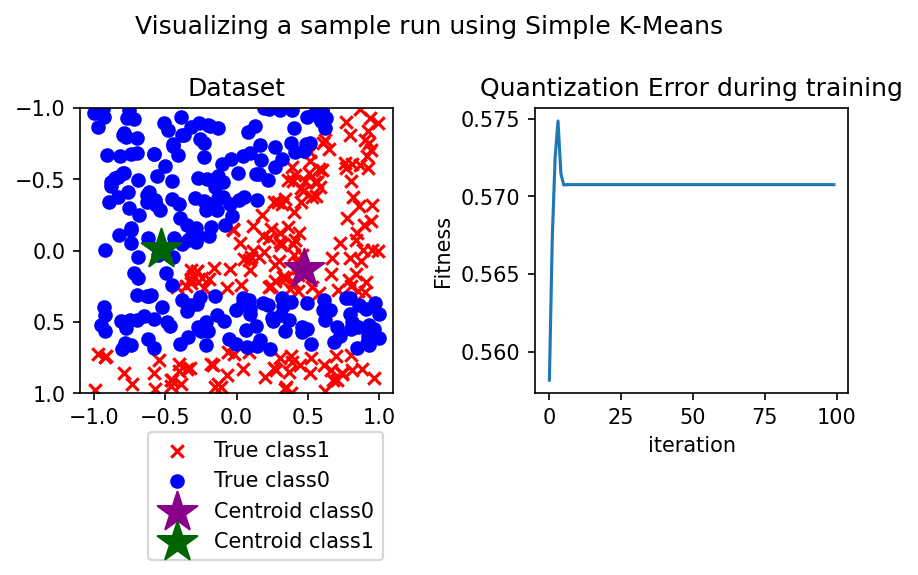

In [18]:
# Visualizing a sample run using K-Means Clustering
dataset = np.random.uniform(-1,1,[400,2])
_, num_dimensions = dataset.shape

# Set Hyperparameters as described
K = 2
iterations = 100
num_inits = 10

best, best_f, fitness_history = K_Means(K, dataset, iterations, num_inits)

cluster_marker = "*"
cluster_color = ["darkmagenta", "darkgreen"]

fig, axs = plt.subplots(1, 2, facecolor="w")

# Plot the results
plot_dataset(axs[0], dataset)
for idx, cluster in enumerate(best):
    axs[0].scatter(cluster[0], cluster[1], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
axs[0].legend(bbox_to_anchor=(1,-0.1), prop={'size': 6}, markerscale=.5)
axs[1].plot(np.arange(len(fitness_history)), fitness_history)
axs[0].title.set_text("Dataset")
axs[1].title.set_text("Quantization Error during training")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("Fitness")
fig.suptitle("Visualizing a sample run using Simple K-Means")
fig.tight_layout()
fig.set_dpi(150)


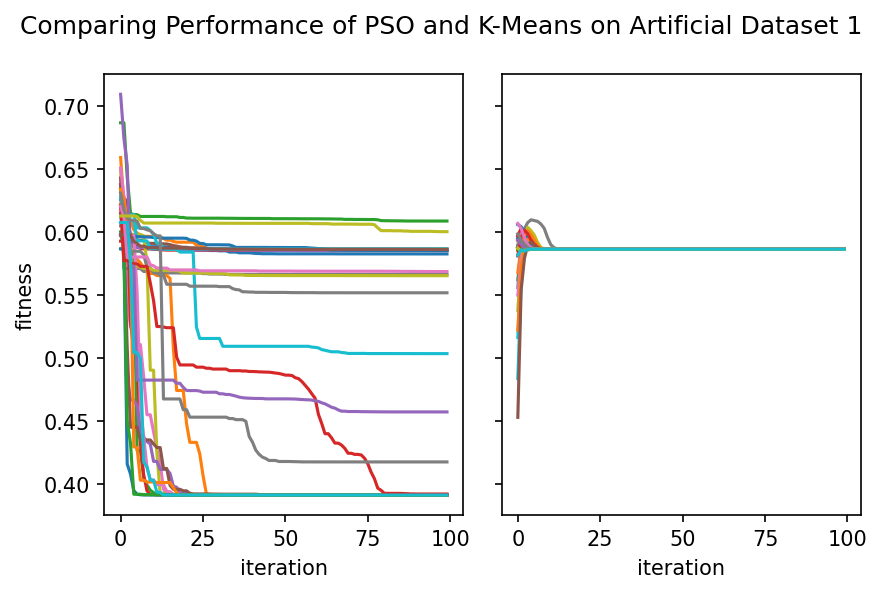

In [40]:
# Set Hyperparameters as described
K = 2
iterations = 100
pop_size = 10
trials = 30
num_inits = 10

omega = 0.72
alpha1 = alpha2 = 1.49

dataset = np.random.uniform(-1,1,[400,2])
_, num_dimensions = dataset.shape

fig, axs = plt.subplots(1,2, facecolor="w", sharex=True, sharey=True)

# Run the 30 trials and plot the results
for i in range(trials):
    best, best_f, fitness_history = k_means_PSO(K, num_dimensions, dataset, pop_size, iterations, omega, alpha1, alpha2)
    axs[0].plot(np.arange(iterations), fitness_history, label=f"Trial {i+1}")
    best, best_f, fitness_history = K_Means(K, dataset, iterations, num_inits)
    axs[1].plot(np.arange(iterations), fitness_history, label=f"Trial {i+1}")

fig.suptitle("Comparing Performance of PSO and K-Means on Artificial Dataset 1")
axs[0].set_xlabel("iteration")
axs[1].set_xlabel("iteration")
axs[0].set_ylabel("fitness")
fig.tight_layout()
fig.set_dpi(150)    

C:\Users\Jan\Storage\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Fitness: 0.5707500201819695


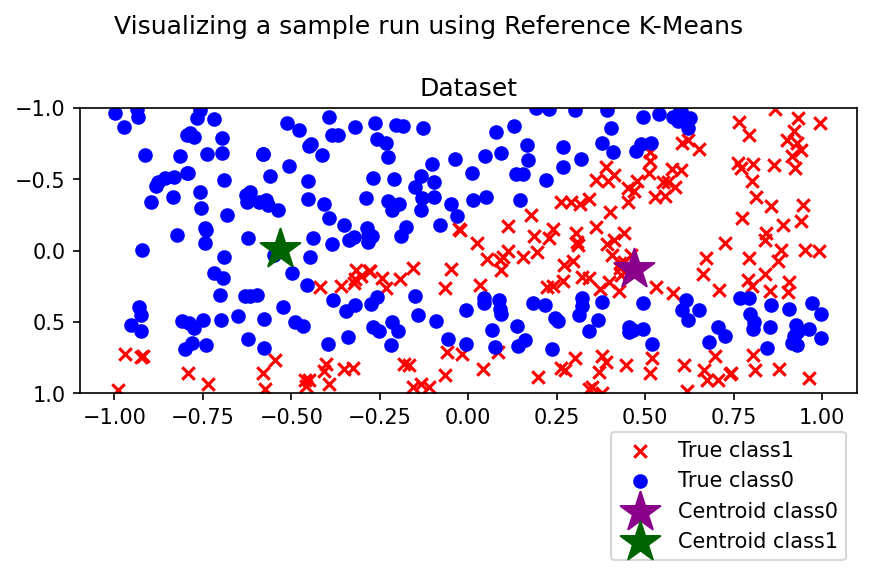

In [20]:
# Compare results with reference implementation
kmeans = sklearn.KMeans(n_clusters=K, n_init=num_inits, max_iter=iterations, init="random", algorithm="full").fit(dataset)
assignments = kmeans.predict(dataset)
fitness = calc_fitness(assignments, dataset, kmeans.cluster_centers_)
print(f"Fitness: {fitness}")

cluster_marker = "*"
cluster_color = ["darkmagenta", "darkgreen"]

fig, axs = plt.subplots(1, facecolor="w")

best_clustering = kmeans.cluster_centers_

# Plot the results
plot_dataset(axs, dataset)
for idx, centroid in enumerate(best_clustering):
    axs.scatter(centroid[0], centroid[1], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
axs.legend(bbox_to_anchor=(1,-0.1))
axs.title.set_text("Dataset")
fig.suptitle("Visualizing a sample run using Reference K-Means")
fig.tight_layout()
fig.set_dpi(150)

Part 2) Applying the Algorithm to the Iris Dataset

In [22]:
# Load in the iris dataset
df = pd.read_csv("iris.data", names=["sepal length", "sepal width", "petal length", "petal width", "label"])
# Get an overview of the data
print(df.shape)
df.head(n=5)

(150, 5)


,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


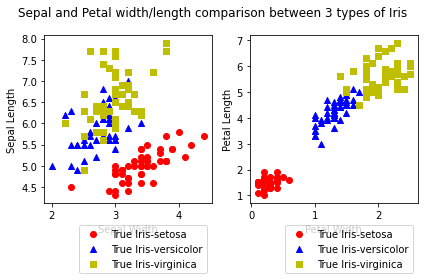

In [23]:
# Plot the "True" clustering
def plot_dataset(axs1, axs2, df):
    # get the class labels from the dataframe
    labels = set(df["label"])

    # Create different markers for each class
    markers = ["o", "^", "s"]
    colors = ["r", "b", "y"]

    # loop over the labels to plot the datapoints for each class
    for idx, label in enumerate(labels):
        mask = df["label"]==label
        data = df[mask]
        #print(data.head())
        axs1.scatter(data["sepal width"], data["sepal length"], marker=markers[idx], color=colors[idx], label=f"True {label}")
        axs2.scatter(data["petal width"], data["petal length"], marker=markers[idx], color=colors[idx], label=f"True {label}")

fig, axs = plt.subplots(1, 2, facecolor="w")
axs1 = axs[0]
axs2 = axs[1]
plot_dataset(axs1, axs2, df)
axs1.legend(bbox_to_anchor=(1,-0.1))
axs2.legend(bbox_to_anchor=(1,-0.1))
axs[0].set_xlabel("Sepal Width")
axs[0].set_ylabel("Sepal Length")
axs[1].set_xlabel("Petal Width")
axs[1].set_ylabel("Petal Length")
fig.suptitle("Sepal and Petal width/length comparison between 3 types of Iris")
fig.tight_layout()


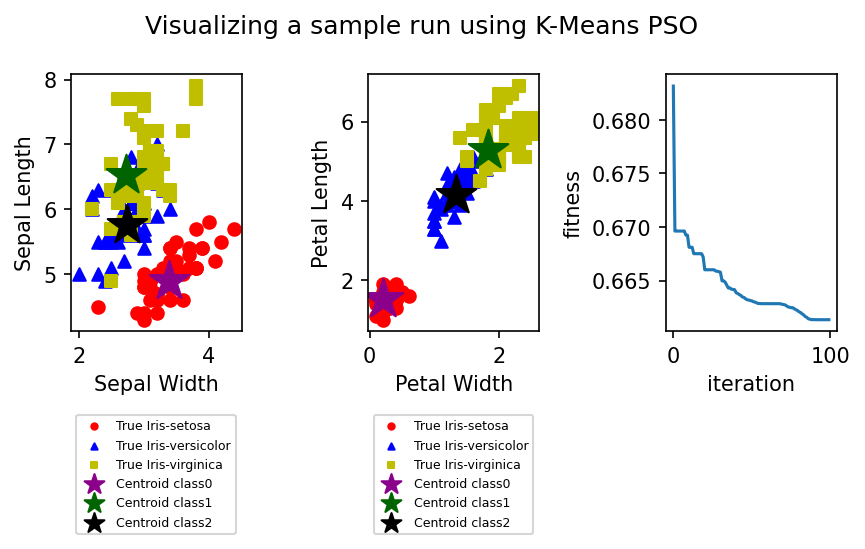

In [29]:
# Visualizing a sample run using K-Means PSO

# Set Hyperparameters as described
K = 3
iterations = 100
pop_size = 10
omega = 0.72
alpha1 = alpha2 = 1.49

dataset = df.iloc[:, :-1].to_numpy()
assert dataset.shape == (df.shape[0], 4)
_, num_dimensions = dataset.shape
best, best_fitness, fitness_history = k_means_PSO(K, num_dimensions, dataset, pop_size, iterations, omega, alpha1, alpha2)

cluster_marker = "*"
cluster_color = ["darkmagenta", "darkgreen", "black"]

fig, axs = plt.subplots(1, 3, facecolor="w")

# Plot the results
plot_dataset(axs[0], axs[1], df)
for idx, cluster in enumerate(best):
    axs[0].scatter(cluster[1], cluster[0], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
    axs[1].scatter(cluster[3], cluster[2], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
#axs[0].legend(loc="best")
axs[2].plot(np.arange(len(fitness_history)), fitness_history)
axs[0].set_xlabel("Sepal Width")
axs[0].set_ylabel("Sepal Length")
axs[1].set_xlabel("Petal Width")
axs[1].set_ylabel("Petal Length")
axs[2].set_xlabel("iteration")
axs[2].set_ylabel("fitness")
fig.suptitle("Visualizing a sample run using K-Means PSO")
axs[0].legend(bbox_to_anchor=(1,-0.3), prop={'size': 6}, markerscale=.5)
axs[1].legend(bbox_to_anchor=(1,-0.3), prop={'size': 6}, markerscale=.5)
fig.tight_layout()
fig.set_dpi(150)


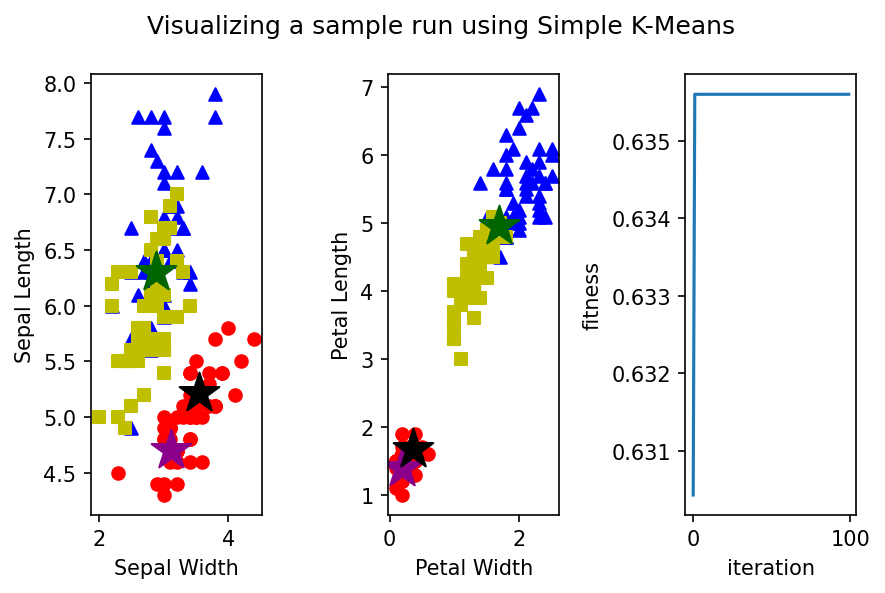

In [15]:
# Visualizing a sample run using K-Means Clustering

# Set Hyperparameters as described
K = 3
iterations = 100
num_inits = 10

dataset = df.iloc[:, :-1].to_numpy()
assert dataset.shape == (df.shape[0], 4)
_, num_dimensions = dataset.shape
best, best_fitness, fitness_history = K_Means(K, dataset, iterations, num_inits)

cluster_marker = "*"
cluster_color = ["darkmagenta", "darkgreen", "black"]

fig, axs = plt.subplots(1, 3, facecolor="w")

# Plot the results
plot_dataset(axs[0], axs[1], df)
for idx, cluster in enumerate(best):
    axs[0].scatter(cluster[1], cluster[0], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
    axs[1].scatter(cluster[3], cluster[2], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
#axs[0].legend(loc="best")
axs[2].plot(np.arange(len(fitness_history)), fitness_history)
axs[0].set_xlabel("Sepal Width")
axs[0].set_ylabel("Sepal Length")
axs[1].set_xlabel("Petal Width")
axs[1].set_ylabel("Petal Length")
axs[2].set_xlabel("iteration")
axs[2].set_ylabel("fitness")
axs[0].legend(bbox_to_anchor=(1,-0.3), prop={'size': 6}, markerscale=.5)
axs[1].legend(bbox_to_anchor=(1,-0.3), prop={'size': 6}, markerscale=.5)
fig.suptitle("Visualizing a sample run using Simple K-Means")
fig.tight_layout()
fig.set_dpi(150)

C:\Users\Jan\Storage\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.6473743892616001


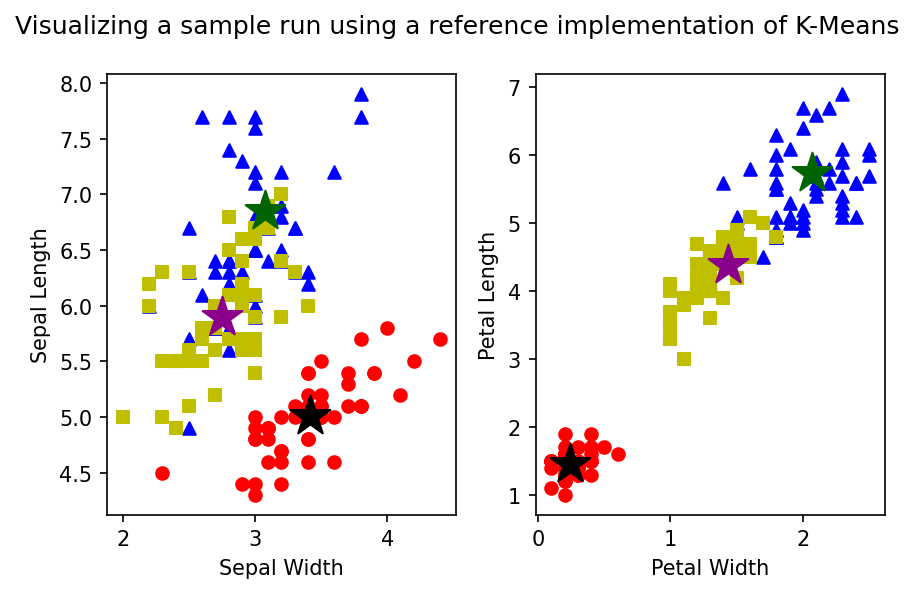

In [18]:
# Comparing to a reference implementation
# Set Hyperparameters as described
K = 3
iterations = 100
num_inits = 10

dataset = df.iloc[:, :-1].to_numpy()
assert dataset.shape == (df.shape[0], 4)

kmeans = sklearn.KMeans(n_clusters=K, n_init=num_inits, max_iter=iterations, init="random", algorithm="full").fit(dataset)
assignments = kmeans.predict(dataset)
fitness = calc_fitness(assignments, dataset, kmeans.cluster_centers_)
print(fitness)

cluster_marker = "*"
cluster_color = ["darkmagenta", "darkgreen", "black"]

fig, axs = plt.subplots(1, 2, facecolor="w")

best_clustering = kmeans.cluster_centers_
# Plot the results
plot_dataset(axs[0], axs[1], df)
for idx, centroid in enumerate(best_clustering):
    axs[0].scatter(centroid[1], centroid[0], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
    axs[1].scatter(centroid[3], centroid[2], marker=cluster_marker, color=cluster_color[idx], label=f"Centroid class{idx}", s=400)
#axs[0].legend(loc="best")
axs[0].set_xlabel("Sepal Width")
axs[0].set_ylabel("Sepal Length")
axs[1].set_xlabel("Petal Width")
axs[1].set_ylabel("Petal Length")
fig.suptitle("Visualizing a sample run using a reference implementation of K-Means")
fig.tight_layout()
fig.set_dpi(150)

C:\Users\Jan\Storage\Anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jan\Storage\Anaconda\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\Jan\Storage\Anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jan\Storage\Anaconda\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\Jan\Storage\Anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jan\Storage\Anaconda\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\Jan\Storage\Anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice

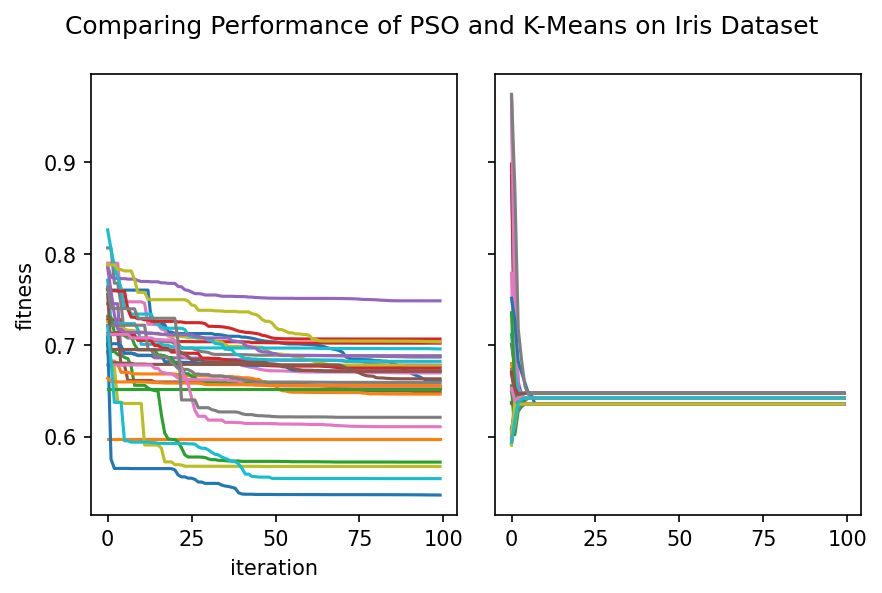

In [35]:
# Running the 30 trials

# Set Hyperparameters as described
K = 3
iterations = 100
pop_size = 10
trials = 30
num_inits = 10

omega = 0.72
alpha1 = alpha2 = 1.49

dataset = df.iloc[:, :-1].to_numpy()
_, num_dimensions = dataset.shape

fig, axs = plt.subplots(1,2, facecolor="w", sharex=True, sharey=True)

# Run the 30 trials and plot the results
for i in range(trials):
    best, best_f, fitness_history = k_means_PSO(K, num_dimensions, dataset, pop_size, iterations, omega, alpha1, alpha2)
    axs[0].plot(np.arange(iterations), fitness_history, label=f"Trial {i+1}")
    best, best_f, fitness_history = K_Means(K, dataset, iterations, num_inits)
    axs[1].plot(np.arange(iterations), fitness_history, label=f"Trial {i+1}")

axs[0].set_xlabel("iteration")
axs[0].set_ylabel("fitness")
fig.suptitle("Comparing Performance of PSO and K-Means on Iris Dataset")
fig.tight_layout()
fig.set_dpi(150)    

(e) To illustrate the clusters formed by both algorithms, plot the clusters created by
a single run of both algorithms. Illustrate your answers with some images (e.g.
true clusters vs predicted clusters) and discuss your findings (write a conclusion
at the end of your analysis).

In [ ]:
# Plot the predicted clustering vs true clustering for a sample run of PSO
# TODO

In [ ]:
# Plot the predicted clustering vs true clustering for a sample run of K-Means
# TODO

[TODO] Discuss the results -> Differences between PSO and K-Means clustering